# **Project 1**

## Import packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

**Data folder**

In [6]:
data_path = "data"

## Load data

In [7]:
def read_data(data_dir , str_cols =[], date_cols =[], date_fmt= None):
    dtype_dic = {i:str for i in str_cols}
    df = pd.read_csv(data_dir, dtype= dtype_dic)
    for i in date_cols:
        df[i] = pd.to_datetime(df[i], format= date_fmt)
    return df

**account**

In [8]:
acc_dir = os.path.join(data_path,'acnt.csv')
str_cols = ['ACNT_NO','ACNT_CLSS','ACNT_STAT','DEPO_CLSS']
date_cols = ['OPNDT','CLOS_DATE']
acc_df = read_data( acc_dir , str_cols, date_cols)

**sub-account**

In [9]:
subacc_dir = os.path.join(data_path,'subacnt.csv')
str_cols = ['ACNT_NO','SUB_ACNT_NO','SUB_ACNT_CLSS']
date_cols = ['OPNDT','CLOS_DATE']
subacc_df = read_data( subacc_dir, str_cols, date_cols, date_fmt = "%Y%m%d")

**order**

In [10]:
ord_dir = os.path.join(data_path,'order.csv')
str_cols = ['SUB_ACNT_NO','FLAG_ORDER']
date_cols = ['TRD_DATE']
ord_df = read_data(ord_dir,str_cols, date_cols, date_fmt = "%Y%m%d")

**nav**

In [11]:
nav_dir = os.path.join(data_path,'nav.csv')
str_cols = ['SUB_ACNT_NO']
date_cols = ['PROC_DATE']
nav_df = read_data(nav_dir,str_cols, date_cols, date_fmt = "%Y%m%d")

## Analysis

In [12]:
rpdate = pd.to_datetime("2024-01-01")

### Pre-processing

In [13]:
# fillter account
acc_ft = acc_df[acc_df['OPNDT'] < rpdate]

In [14]:
# merge account with sub -account
subacc_df = subacc_df[['ACNT_NO', 'SUB_ACNT_NO']]
acc_merge = acc_ft.merge(subacc_df, how = 'inner')

In [15]:
# acc list - acc unique
acc_ls = acc_ft[['ACNT_NO', 'OPNDT', 'CLOS_DATE']].copy()
# recency_opn is open acc in time form 1 to 59
acc_ls['recency_opn'] = acc_ls['OPNDT'] > (rpdate - pd.Timedelta(days = 60))
acc_ls['closed'] = ~acc_ls['CLOS_DATE'].isna()

In [16]:
# check acc is unique 
acc_ls['ACNT_NO'].is_unique

True

### Recency

In [17]:
# merge acc_merge with order
rec = acc_merge.merge(ord_df, how = 'left')

In [18]:
# chosse last trd date and numbering for acc have trd
acc_trd = rec.groupby('ACNT_NO')['TRD_DATE'].max().reset_index()
acc_trd = acc_trd.rename({'TRD_DATE':'MAC_TRD_DATE'}, axis =1)

# MAX_TRD_DATE = False --> 'non_trade' = True
acc_trd['non_trd'] = acc_trd['MAC_TRD_DATE'].isna()

In [19]:
# merge acc_trd with acc_ls
acc_ls = acc_ls.merge(acc_trd, how = 'left')

In [20]:
# label for all recency_group

## acc_closed -->0
acc_ls.loc[acc_ls['closed'], 'recency_grp'] = '0'

## non_closed + non trade in + recency_opne 1to59 days-->1
non_trade_condi = (~acc_ls['closed']) & (acc_ls['non_trd'])
acc_ls.loc[non_trade_condi & (acc_ls['recency_opn']), 'recency_grp'] = '1'

## non_closed + non trade in + recency open over_equal 60 days-->0
acc_ls.loc[non_trade_condi & (~acc_ls['recency_opn']), 'recency_grp'] = '0'

# Have trade
trd_codi = ~non_trade_condi
in_range_1to59 = (acc_ls['MAC_TRD_DATE'] >= (rpdate - pd.Timedelta(days = 59))) & (acc_ls['MAC_TRD_DATE'] < rpdate)
in_range_60to179 = (acc_ls['MAC_TRD_DATE'] >= (rpdate - pd.Timedelta(days = 179))) & (acc_ls['MAC_TRD_DATE'] < (rpdate - pd.Timedelta(days = 60)))
in_range_180to365 = (acc_ls['MAC_TRD_DATE'] >= (rpdate - pd.Timedelta(days = 364))) & (acc_ls['MAC_TRD_DATE'] < (rpdate - pd.Timedelta(days = 180)))
out_range_365 = (acc_ls['MAC_TRD_DATE'] <= (rpdate - pd.Timedelta(days = 365)))
acc_ls.loc[trd_codi & in_range_1to59, 'recency_grp'] = '3'
acc_ls.loc[trd_codi & in_range_60to179, 'recency_grp'] = '2'
acc_ls.loc[trd_codi & in_range_180to365, 'recency_grp'] = '1'
acc_ls.loc[trd_codi & out_range_365, 'recency_grp'] = '0'

### Frequency and Monetary

In [21]:
# acc_closed 
acc_ls.loc[acc_ls['closed'], ['frequency_grp','monatery_grp']] = '0'

## non_closed + non trade in + recency_opne 1to59 days-->1
non_trade_condi = (~acc_ls['closed']) & (acc_ls['non_trd'])
in_range_1to59 = (acc_ls['OPNDT'] >= (rpdate - pd.Timedelta(days = 59))) & (acc_ls['OPNDT'] < rpdate)
acc_ls.loc[non_trade_condi & in_range_1to59, ['frequency_grp','monatery_grp']] = '1'

## non_closed + non trade in + recency_opne over_equals 60 days-->0
out_range_60 = (acc_ls['OPNDT'] >= (rpdate - pd.Timedelta(days = 60)))
acc_ls.loc[non_trade_condi & out_range_60,['frequency_grp','monatery_grp']] = '0'

## have trade
trd_condi = ~non_trade_condi

In [22]:
## MMO account
ord_agg = rec.groupby('ACNT_NO').agg({'TRD_DATE' : 'max','COUNT_ORDER': 'sum','TRD_VALUE': 'sum'})
mmo = ord_agg[
    (ord_agg['TRD_DATE'] >= '2022-01-01')&
    (ord_agg['COUNT_ORDER'] == 1) &
    (ord_agg['TRD_VALUE'] < 16000)
]
acc_ls['mmo'] = acc_ls['ACNT_NO'].isin(mmo.index)
acc_ls.loc[acc_ls['mmo'], ['frequency_grp','monatery_grp']] = '0'

In [23]:
# change name cols to understand when check 
ord_agg = ord_agg.rename({'COUNT_ORDER' : 'TOTAL_ORDER', 'TRD_VALUE': 'TOTAL_TRD_VALUE'}, axis = 1)
# reset ord_agg to sort 
ord_agg = ord_agg.reset_index()

In [24]:
# merge ord_agg with acc_ls
acc_ls = acc_ls.merge(ord_agg[['ACNT_NO','TOTAL_ORDER','TOTAL_TRD_VALUE']], how = 'left')

In [25]:
# active acc with no MMO
acc_ls['act_no_mmo'] = (~acc_ls['closed']) & (~acc_ls['mmo']) & (~acc_ls['non_trd'])
acc_ls['acc_lifetime'] = (rpdate - acc_ls['OPNDT'])/pd.Timedelta(days=1)

# accounts that have an open date in last 1 year up to report date
acc_ls['flag_adj'] = acc_ls['acc_lifetime'] <= 365

In [26]:
acc_ls.loc[acc_ls['flag_adj'], 'TOTAL_ORDER'] = 365/acc_ls.loc[acc_ls['flag_adj'], 'acc_lifetime']*acc_ls.loc[acc_ls['flag_adj'], 'TOTAL_ORDER']
acc_ls.loc[acc_ls['flag_adj'], 'TOTAL_TRD_VALUE'] = 365/acc_ls.loc[acc_ls['flag_adj'], 'acc_lifetime']*acc_ls.loc[acc_ls['flag_adj'], 'TOTAL_TRD_VALUE']

In [27]:
# active account not mmo have trading count
trd_count_act_no_mmo = acc_ls.loc[acc_ls['act_no_mmo'], 'TOTAL_ORDER']
acc_ls.loc[acc_ls['act_no_mmo'] & (acc_ls['TOTAL_ORDER'] <= trd_count_act_no_mmo.quantile(0.5)), 'frequency_grp'] = '1'
acc_ls.loc[acc_ls['act_no_mmo'] & 
        (acc_ls['TOTAL_ORDER'] > trd_count_act_no_mmo.quantile(0.5)) &
        (acc_ls['TOTAL_ORDER'] <= trd_count_act_no_mmo.quantile(0.95)),
        'frequency_grp'] = '2'
acc_ls.loc[acc_ls['act_no_mmo'] & (acc_ls['TOTAL_ORDER'] > trd_count_act_no_mmo.quantile(0.95)), 'frequency_grp'] = '3'



# active account not mmo have trading value
trd_value_act_no_mmo =  acc_ls.loc[acc_ls['act_no_mmo'], 'TOTAL_TRD_VALUE']
acc_ls.loc[acc_ls['act_no_mmo'] & (acc_ls['TOTAL_TRD_VALUE'] <= trd_value_act_no_mmo.quantile(0.5)), 'monatery_grp'] = '1'
acc_ls.loc[acc_ls['act_no_mmo'] & 
        (acc_ls['TOTAL_TRD_VALUE'] > trd_value_act_no_mmo.quantile(0.5)) &
        (acc_ls['TOTAL_TRD_VALUE'] <= trd_value_act_no_mmo.quantile(0.95)),
        'monatery_grp'] = '2'
acc_ls.loc[acc_ls['act_no_mmo'] & (acc_ls['TOTAL_TRD_VALUE'] > trd_value_act_no_mmo.quantile(0.95)), 'monatery_grp'] = '3'

### NAV

In [28]:
nav_acc = nav_df.merge(subacc_df).groupby(['ACNT_NO','PROC_DATE'])['NAV'].sum()

In [29]:
nav_acc = nav_acc.reset_index()

In [30]:
# the average in last 30 days
l30d = nav_acc[(nav_acc['PROC_DATE'] >= (rpdate - pd.Timedelta(days = 30))) & (nav_acc['PROC_DATE'] < rpdate)]
l30d_nav_mean = l30d.groupby('ACNT_NO', as_index = False)['NAV'].mean().rename(columns = {'NAV' : 'NAV_30D'})

#the average in last 90 days
l90d = nav_acc[(nav_acc['PROC_DATE'] >= (rpdate - pd.Timedelta(days = 90))) & (nav_acc['PROC_DATE'] < rpdate)]
l90d_nav_mean = l90d.groupby('ACNT_NO', as_index = False)['NAV'].mean().rename(columns = {'NAV' : 'NAV_90D'})

In [31]:
# merge l30d_nav_mean with l90d_nav_mean
nav_mean  = l30d_nav_mean.merge(l90d_nav_mean, how = 'outer')

# merge nav_mean with acc_ls
acc_ls = acc_ls.merge(nav_mean, how = 'left')

In [32]:
# NAV 90days >= 50k
condi = acc_ls['NAV_90D'] >= 50000
nav_q50 = acc_ls.loc[condi, 'NAV_30D'].quantile(0.5)
nav_q90 = acc_ls.loc[condi, 'NAV_30D'].quantile(0.9)

acc_ls.loc[(~condi) | ( (acc_ls['NAV_30D'].isna()) | (acc_ls['closed']) ), 'nav_grp'] = '0'
acc_ls.loc[condi & (acc_ls['NAV_30D'] <= nav_q50), 'nav_grp'] = '1'
acc_ls.loc[condi & (acc_ls['NAV_30D'] > nav_q50) & (acc_ls['NAV_30D'] < nav_q90), 'nav_grp'] = '2'
acc_ls.loc[condi & (acc_ls['NAV_30D'] > nav_q90), 'nav_grp'] = '3'

### Group combination

In [33]:
acc_ls['RFMN'] = acc_ls['recency_grp'] + acc_ls['frequency_grp'] + acc_ls['monatery_grp'] + acc_ls['nav_grp'] 

In [34]:
vip = ['2333', '3333']
promising = ['3331', '3233', '3232', '3133', '3132', '2332', '2233', '2232', '2133', '2132', '1333', '1332', '1233', '3332']
loyal = ['3323', '3322', '3321', '3313', '3312', '2323', '2322', '2313', '2312']
regular = ['3330', '3320', '3311', '3303', '3302', '3231', '3223', '3222', '3221', '3213','3212', '3211', '3203', '3202', '3131', '3123', '3122', '3121', '3113', '3112','3033', '2331','2330', '2321', '2320', '2311', '2303', '2302', '2231', '2223', '2222', '2221', '2213', '2212', '2131', '2123', '2122', '2121', '2113', '2112', '2033', '1323', '1223', '1133']
sleeping = ['3310', '3301', '3230', '3220', '3210', '3201', '3130', '3120', '3111', '3110','3103', '3102', '3101', '3032', '3031', '3030', '3023', '3022', '3021', '3020','3013', '3012','3011', '3003', '3002', '2310', '2301', '2230', '2220', '2211','2210', '2203', '2202', '2201', '2130', '2120', '2111', '2110', '2103', '2102','2101', '2032', '2031', '2030', '2023','2022', '2021', '2013', '2012', '2011','2003', '1331', '1330', '1322', '1321', '1320', '1313', '1312', '1311', '1310','1303', '1302', '1301', '1232', '1231', '1230', '1222', '1221','1220', '1213','1212', '1211', '1210', '1203', '1202', '1201', '1132', '1131', '1130', '1123','1122', '1121', '1120', '1113', '1112', '1111', '1110', '1103', '1102', '1101','1033','1032', '1031', '1023', '1022', '1021', '1013', '1012','1011', '1003','0333', '0332', '0331', '0330', '0323', '0322', '0321', '0313', '0312', '0303','0302', '0233', '0232', '0231', '0223', '0222', '0221', '0213', '0212', '0203','0202', '0133', '0132', '0123', '0122', '0113', '0103', '0033', '0032', '0023','0013', '0003']
churn = ['3300','3200', '3100', '3010', '3001', '3000', '2300', '2200', '2100', '2020','2010', '2002', '2001', '2000', '1300', '1200', '1100', '1030', '1020', '1010','1002', '1001', '1000', '0320', '0311', '0310', '0301', '0300', '0230', '0220','0211', '0210', '0201', '0200', '0131', '0130', '0121', '0120', '0112', '0111','0110', '0102', '0101', '0100', '0031', '0030', '0022', '0021', '0020', '0012','0011', '0010', '0002', '0001', '0000']
acc_ls.loc[acc_ls['RFMN'].isin(vip), 'label'] = 'VIP'
acc_ls.loc[acc_ls['RFMN'].isin(promising), 'label'] = 'PROMISING'
acc_ls.loc[acc_ls['RFMN'].isin(loyal), 'label'] = 'LOYAL'
acc_ls.loc[acc_ls['RFMN'].isin(regular), 'label'] = 'REGULAR'
acc_ls.loc[acc_ls['RFMN'].isin(sleeping), 'label'] = 'SLEEPING'
acc_ls.loc[acc_ls['RFMN'].isin(churn), 'label'] = 'CHURN'

In [35]:
acc_ls['label'].value_counts()

label
CHURN        10466
REGULAR       5201
SLEEPING      1674
PROMISING      230
LOYAL          218
VIP            137
Name: count, dtype: int64

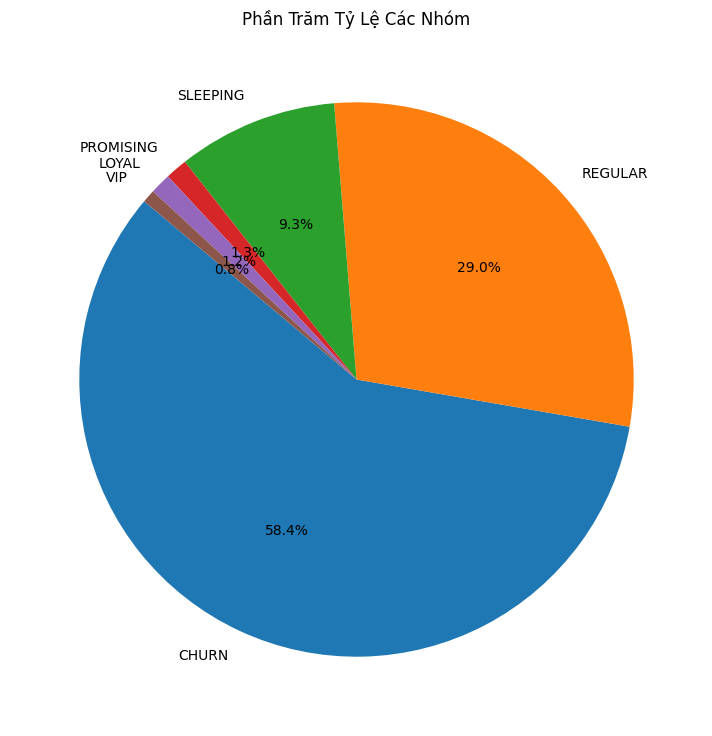

In [36]:
label_counts = acc_ls['label'].value_counts()
label_percentages = label_counts / label_counts.sum() * 100
# Vẽ biểu đồ hình tròn
plt.figure(figsize=(13,9))
plt.pie(label_percentages, labels=label_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Phần Trăm Tỷ Lệ Các Nhóm')
plt.show()